In [1]:
import numpy as np
from cycler import cycler

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
default_cycler = cycler(color=['firebrick', 'green'])
plt.rc('axes', prop_cycle=default_cycler)

In [4]:
from firing_signals.sampling.bffs import backward_filtering_forward_sampling

In [5]:
N, Tr = 20, 1
L, M = 10, 50 # num neurons, num synapses per neuron

In [6]:
origins = np.random.randint(0, L, (L, M))
delays = np.random.uniform(0, Tr, (L, M))

# Impulse response

In [7]:
beta = 0.5
h = lambda t : (t>0) * t/beta * np.exp(1 - t/beta)

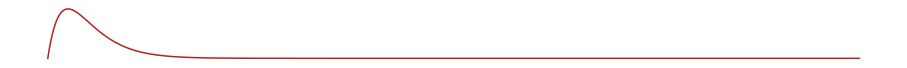

In [8]:
plt.figure(figsize=(16,1))
plt.plot(np.linspace(0, 20, 1000), h(np.linspace(0, 20, 1000)))
plt.axis("off")
plt.show()

# Spike generation

In [9]:
theta = 0.
sigma_th = lambda z_ : z_ >= theta

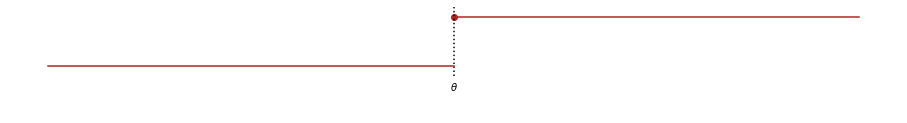

In [10]:
plt.figure(figsize=(16,2))

plt.plot(np.linspace(-10, theta-1e-6, 100), sigma_th(np.linspace(-10, theta-1e-6, 100)), color="firebrick")
plt.plot(np.linspace(theta, 10, 100), sigma_th(np.linspace(theta, 10, 100)), color="firebrick")
plt.scatter(theta, 1)
plt.vlines(theta, -0.2, 1.2, linestyle="dotted", color="black")
plt.annotate(r"$\theta$", (theta, -0.5), ha="center")
plt.ylim(-1, 1.2)
plt.axis("off")
plt.show()

# Spiking neurons

Suppose a neuron is connected to $L$ neurons through $M$ synapses. Each synapse has a delay (information does not propagate instantaneously) and a learnable weight. Moreover, each neuron of the neural network has to learn a sequence $y \in \mathcal{Y}_{T_r}^N$, indicating for each point on a discrete grid if a fire occurs or not.

In [11]:
y = np.array([backward_filtering_forward_sampling(N, Tr) for _ in range(L)])

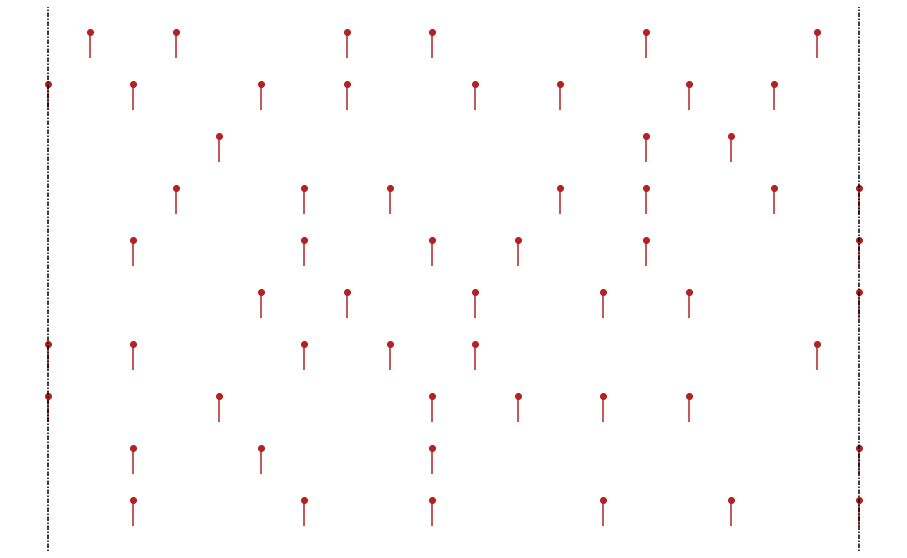

In [12]:
plt.figure(figsize=(16,L))
grid = np.arange(0, N)

for l in range(L):
    mask = y[l] > 0
    plt.stem(grid[mask], 2*l + y[l, mask], bottom=2*l, basefmt=" ")
    
plt.axvline(0, linestyle=(10,(3, 1, 1, 1)), color="black")
plt.axvline(N-1, linestyle=(10,(3, 1, 1, 1)), color="black")
plt.axis('off')
    
plt.show()

To generate a spike, the neuron should be activated by the network, through its synapses. At time $t$, the contribution of each synapse is given by :
\begin{equation}
z_{m} (t) = \sum_{t_s \in T_m} h(t - t_s - \tau_m)
\end{equation}
where the sum is over $T_m$, the set of firing times of the neuron at the origin of the synapse.

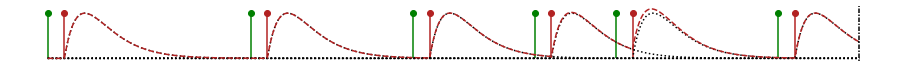

In [13]:
# signal in synapse m
m, k = 1, 9

y_m = y[origins[l, m]]

grid = np.arange(-N, 0)
mask = (grid) * np.roll(y_m, -k, axis=0) < 0

plt.figure(figsize=(16,1))
plt.stem(grid[mask], np.ones_like(grid[mask]), linefmt="C1-", markerfmt="C1o", basefmt=" ")

grid_d = np.arange(-N, 0) + delays[l, m]
mask_d = (grid_d) * np.roll(y_m, -k, axis=0) < 0
plt.stem(grid_d[mask_d], np.ones_like(grid_d[mask_d]), basefmt=" ")

plt.axvline(0, linestyle=(10,(3, 1, 1, 1)), color="black")


T = np.linspace(-N, 0, 1000)
for t_ds in grid_d[mask]:
    plt.plot(T, h(T - t_ds), color="black", linestyle="dotted")
    
plt.plot(T, np.sum(h(T[None,:]-grid_d[mask][:,None]), axis=0), linestyle="dashed")
plt.axis('off')
plt.show()

Given a sequence to learn, and assuming the firings occure on a discrete grid, the score related to each synapses is fixed at any time on the grid. The goal now is to learn the weights such that the neuron can reproduce the given sequence.

# Learning

The weights are learned using half-box learning via gradient descent with box constraint on the weights

In [14]:
alpha = 10
grad_loss_fit = lambda w_, z_, y_ : 1/N * np.dot(np.sign(np.dot(z_,w_) - theta)+(-1)**y_, z_)
grad_loss_reg = lambda w_ : np.sign(w_+1) + np.sign(w_-1)
grad_loss = lambda w_, z_, y_ : grad_loss_fit(w_, z_, y_) + alpha * grad_loss_reg(w_)

In [15]:
grid = np.arange(-N, 0)
z = np.sum([h(-grid[None,None,:]-delays[:,:,None]) * np.roll(y[origins], -n, axis=-1) for n in range(N)], axis=-1)

In [29]:
eta = 1e-3

weights = np.random.uniform(-1, 1, (L, M))

for l in range(L):
    free_indices = [k for k in range(N) if np.sum(np.roll(y[l], -k)[...,-Tr:]) < 1]

    for _ in range(10000):
        weights[l] -= eta * grad_loss(weights[l], z[free_indices, l], y[l, free_indices])

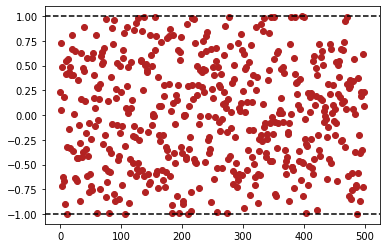

In [30]:
plt.scatter(np.arange(M*L), weights)
plt.axhline(-1, linestyle="dashed", color="black")
plt.axhline(1, linestyle="dashed", color="black")
plt.show()

In [31]:
for l in range(L):
    y_hat = np.zeros(N, dtype=np.int32)
    free_indices = [k for k in range(N) if np.sum(np.roll(y[l], -k)[...,-Tr:]) < 1]
    y_hat[free_indices] = np.inner(weights[l], z[free_indices, l]) >= theta
    print(f"neuron {l} : {np.all(y_hat == y[l])}")

neuron 0 : True
neuron 1 : True
neuron 2 : True
neuron 3 : True
neuron 4 : True
neuron 5 : True
neuron 6 : True
neuron 7 : True
neuron 8 : True
neuron 9 : True


When initialized with the whole sequence, it is able to reproduce it perfectly

In [32]:
grid = np.arange(-N, 0)

hat_y = np.zeros((L, 4*N), dtype=np.int32)
hat_y[:,:N] = y

for n in range(N, 4*N):
    for l in range(L):
        if np.sum(hat_y[l, n-Tr:n]) > 0:
            hat_y[l, n] = 0
        else:
            zn = np.sum(h(-grid[None,:]-delays[l, :,None]) * hat_y[origins[l], n-N:n], axis=-1)
            hat_y[l, n] = np.inner(zn, weights[l]) >= theta

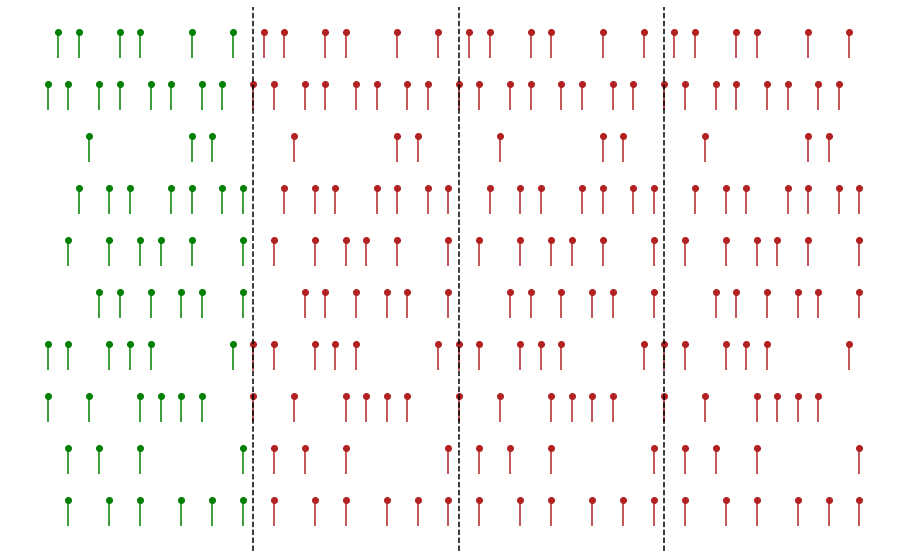

In [33]:
grid_ = np.arange(0, 4*N)
init = grid_ < N

plt.figure(figsize=(16,L))
for l in range(L):
    mask = hat_y[l] > 0
    plt.stem(grid_[mask & ~init], 2*l+hat_y[l, mask & ~init], bottom=2*l, basefmt=" ")
    plt.stem(grid_[mask & init], 2*l+hat_y[l, mask & init], bottom=2*l, linefmt="C1-", markerfmt="C1o", basefmt=" ")

plt.axvline(N, linestyle="dashed", color="black")
plt.axvline(2*N, linestyle="dashed", color="black")
plt.axvline(3*N, linestyle="dashed", color="black")

plt.axis('off')
    
plt.show()

WHAT HAPPENED IF NOT INITIALIZED WITH THE WHOLE SEQUENCE??

In [34]:
N_ = 7
grid = np.arange(-N_, 0)

hat_y = np.zeros((L, 4*N), dtype=np.int32)
hat_y[...,:N_] = y[...,:N_]

for n in range(N_, 4*N):
    for l in range(L):
        if np.sum(hat_y[l, n-Tr:n]) > 0:
            hat_y[l, n] = 0
        else:
            zn = np.sum(h(-grid[None,:]-delays[l, :,None]) * hat_y[origins[l], n-N_:n], axis=-1)
            hat_y[l, n] = np.inner(zn, weights[l]) >= theta

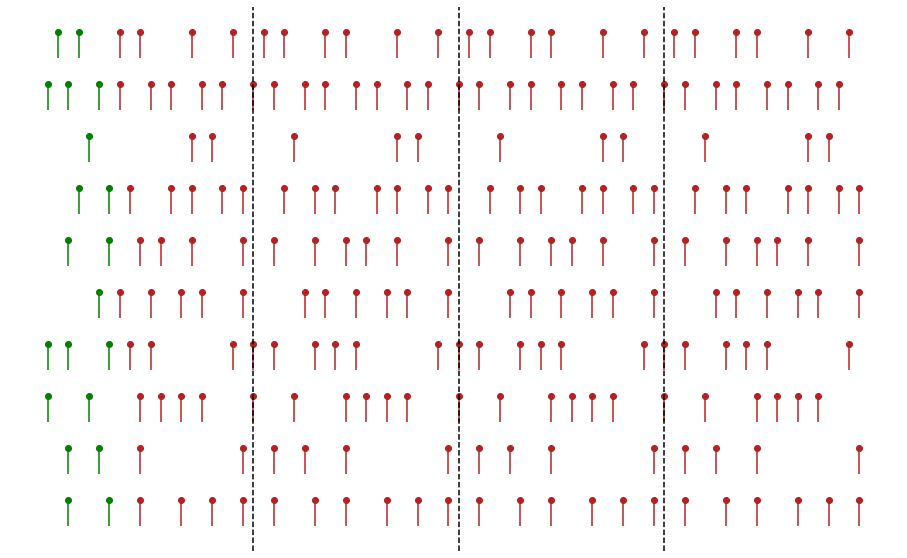

In [35]:
grid_ = np.arange(0, 4*N)
init = grid_ < N_

plt.figure(figsize=(16,L))
for l in range(L):
    mask = hat_y[l] > 0
    plt.stem(grid_[mask & ~init], 2*l+hat_y[l, mask & ~init], bottom=2*l, basefmt=" ")
    plt.stem(grid_[mask & init], 2*l+hat_y[l, mask & init], bottom=2*l, linefmt="C1-", markerfmt="C1o", basefmt=" ")

plt.axvline(N, linestyle="dashed", color="black")
plt.axvline(2*N, linestyle="dashed", color="black")
plt.axvline(3*N, linestyle="dashed", color="black")

plt.axis('off')
    
plt.show()